# Импорт библиотек

In [2]:
import numpy as np
from matplotlib import pylab as plt
from importlib import reload

from gradient_approximation import *
from optimizers import *
from utils import *
from run_experiments import *

%load_ext autoreload
%autoreload 2

## 2. Логистическая регрессия

In [2]:
func_name = "mushrooms"
d = 112
SEED = 18

mu = 0.1
L = 2.5

args = init_experiment(func_name, d, alpha=mu)

np.random.seed(SEED)
x_0 = np.random.random(size=d)
x_0 = x_0 / np.linalg.norm(x_0) * 0.5

In [3]:
def learning_rate_GD(k):
    return 1./L

Sets:
1. Simplex
$$w^k = \arg\min_{w \in d \Delta_d} f(x^k - \eta w \odot \nabla f(x^k))$$
2. Cube
$$w^k = \arg\min_{w \in [0, 1]^d} f(x^k - \eta w \odot \nabla f(x^k))$$

Strategies:
1. Greedy: $$g_k[argsort(-w)[:k]]$$
2. Greedy Weighted: $$(w * g_k)[argsort(-w)[:k]]$$
3. Weighted Greedy: $$(w * g_k)[argsort(-|w * g_k|)[:k]]$$

 67%|██████▋   | 1126/1675 [00:23<00:11, 48.26it/s]


Precision 1e-06 achieved at step 1126!


 66%|██████▌   | 1101/1675 [06:04<03:10,  3.02it/s]


Precision 1e-06 achieved at step 1101!


 66%|██████▌   | 1103/1675 [04:21<02:15,  4.23it/s]


Precision 1e-06 achieved at step 1103!


 67%|██████▋   | 1114/1675 [04:22<02:12,  4.25it/s]


Precision 1e-06 achieved at step 1114!


100%|██████████| 1675/1675 [06:23<00:00,  4.37it/s]


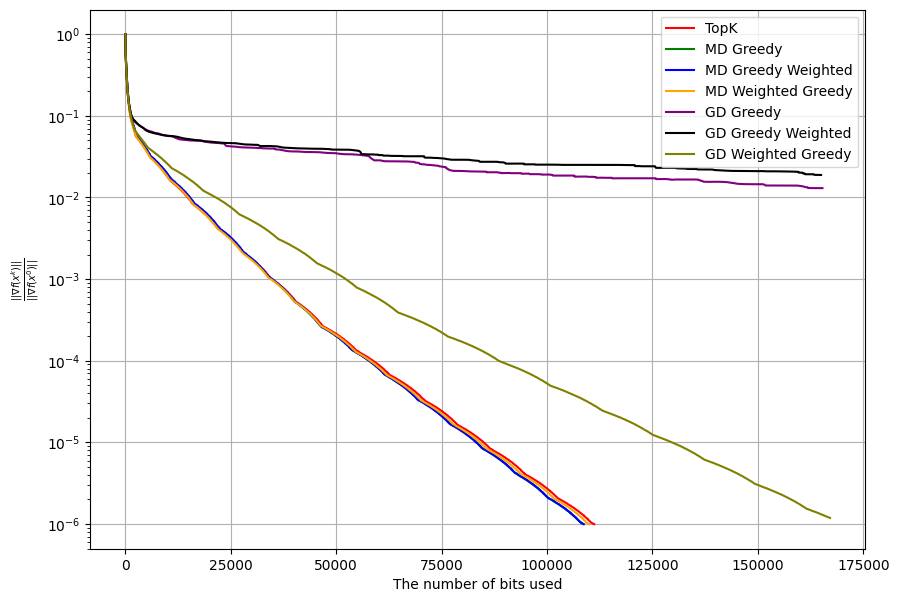

In [5]:
np.random.seed(SEED)
use_ratio = 0.2

grad = lambda x: logreg_grad(x, args['X'], args['y'], args['alpha'])

compressors = [GreedyCompressor(grad, len(x_0), use_ratio)]
compressors += [MirrorDescentGreedyCompressor(grad, 1./L, len(x_0), use_ratio)]
compressors += [MirrorDescentGreedyWeightedCompressor(grad, 1./L, len(x_0), use_ratio)]
compressors += [MirrorDescentWeightedTopkCompressor(grad, 1./L, len(x_0), use_ratio)]
compressors += [GradientDescentGreedyCompressor(grad, 1./L, len(x_0), use_ratio)]
compressors += [GradientDescentGreedyWeightedCompressor(grad, 1./L, len(x_0), use_ratio)]
compressors += [GradientDescentWeightedTopkCompressor(grad, 1./L, len(x_0), use_ratio)]


approximators = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors]

num_calls = 3 * 10**5

optimizers_list = [
    GDOptimizer(approximator, 1./L, x_0, max_bits=num_calls) for approximator in approximators
]

for opt in optimizers_list:
    opt.optimize()
make_err_plot(optimizers_list, labels=["TopK", "MD Greedy", "MD Greedy Weighted", "MD Weighted Greedy", "GD Greedy", "GD Greedy Weighted", "GD Weighted Greedy"], title="")

100%|██████████| 55/55 [00:36<00:00,  1.50it/s]


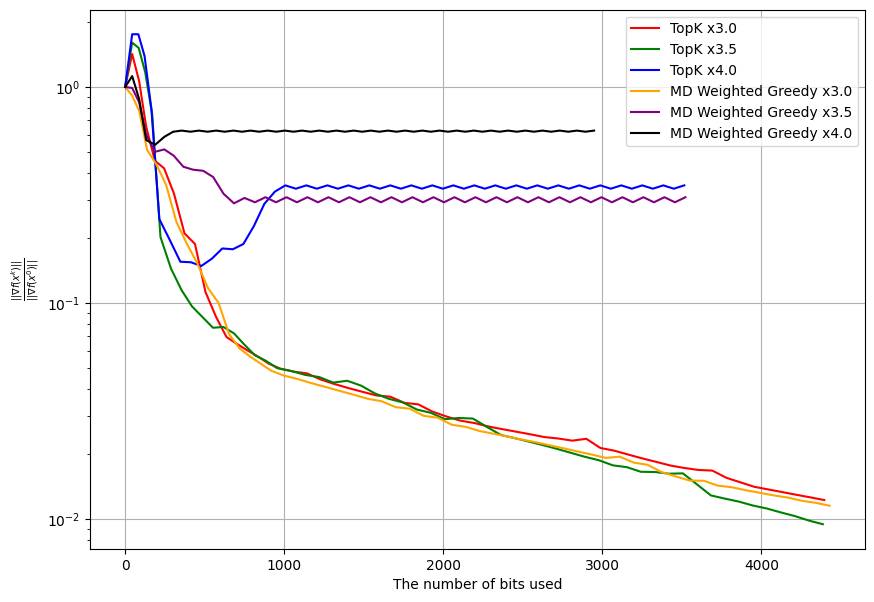

In [5]:
np.random.seed(SEED)
use_ratio = 0.2

grad = lambda x: logreg_grad(x, args['X'], args['y'], args['alpha'])
lr_multipliers = [3., 3.5, 4.]

compressors1 = []
for lr_multiplier in lr_multipliers:
    compressors1 += [GreedyCompressor(grad, len(x_0), use_ratio)]

compressors2 = []
for lr_multiplier in lr_multipliers:
    compressors2 += [MirrorDescentWeightedTopkCompressor(grad, lr_multiplier/L, len(x_0), use_ratio)]

approximators1 = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors1]
approximators2 = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors2]

num_calls = 10**4

optimizers_list = [
    GDOptimizer(approximator, lr_multiplier/L, x_0, max_bits=num_calls) for lr_multiplier, approximator in zip(lr_multipliers, approximators1)
]

optimizers_list += [
    GDOptimizer(approximator, lr_multiplier/L, x_0, max_bits=num_calls) for lr_multiplier, approximator in zip(lr_multipliers, approximators2)
]

for opt in optimizers_list:
    opt.optimize()
make_err_plot(optimizers_list, labels=[f"TopK x{lr}" for lr in lr_multipliers] + [f"MD Weighted Greedy x{lr}" for lr in lr_multipliers], title="")

 65%|██████▌   | 363/558 [00:07<00:04, 46.04it/s]


Precision 1e-06 achieved at step 363!


 85%|████████▍ | 474/558 [06:13<01:06,  1.27it/s]


Precision 1e-06 achieved at step 474!


 47%|████▋     | 262/558 [03:20<03:46,  1.31it/s]


Precision 1e-06 achieved at step 262!


 31%|███▏      | 175/558 [01:30<03:18,  1.93it/s]


Precision 1e-06 achieved at step 175!


100%|██████████| 558/558 [02:43<00:00,  3.41it/s]


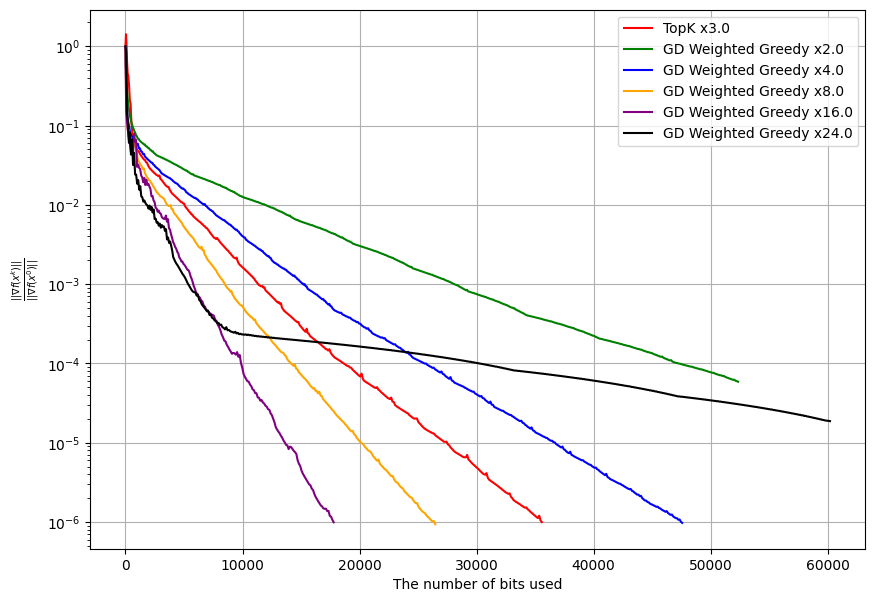

In [21]:
np.random.seed(SEED)
use_ratio = 0.2

grad = lambda x: logreg_grad(x, args['X'], args['y'], args['alpha'])
lr_multipliers = [2., 4., 8., 16., 24.]

compressors1 = [GreedyCompressor(grad, len(x_0), use_ratio)]

compressors2 = []
for lr_multiplier in lr_multipliers:
    compressors2 += [GradientDescentWeightedTopkCompressor(grad, lr_multiplier/L, len(x_0), use_ratio)]

approximators1 = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors1]
approximators2 = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors2]

num_calls = 10**5

optimizers_list = [
    GDOptimizer(approximator, lr_multiplier/L, x_0, max_bits=num_calls) for lr_multiplier, approximator in zip([3.], approximators1)
]

optimizers_list += [
    GDOptimizer(approximator, lr_multiplier/L, x_0, max_bits=num_calls) for lr_multiplier, approximator in zip(lr_multipliers, approximators2)
]

for opt in optimizers_list:
    opt.optimize()
make_err_plot(optimizers_list, labels=[f"TopK x{3.}"] + [f"GD Weighted Greedy x{lr}" for lr in lr_multipliers], title="")

 76%|███████▋  | 299/391 [00:05<00:01, 50.87it/s]


Precision 1e-06 achieved at step 299!


 92%|█████████▏| 361/391 [02:30<00:12,  2.40it/s]


Precision 1e-06 achieved at step 361!


 45%|████▍     | 175/391 [00:56<01:09,  3.12it/s]

Precision 1e-06 achieved at step 175!


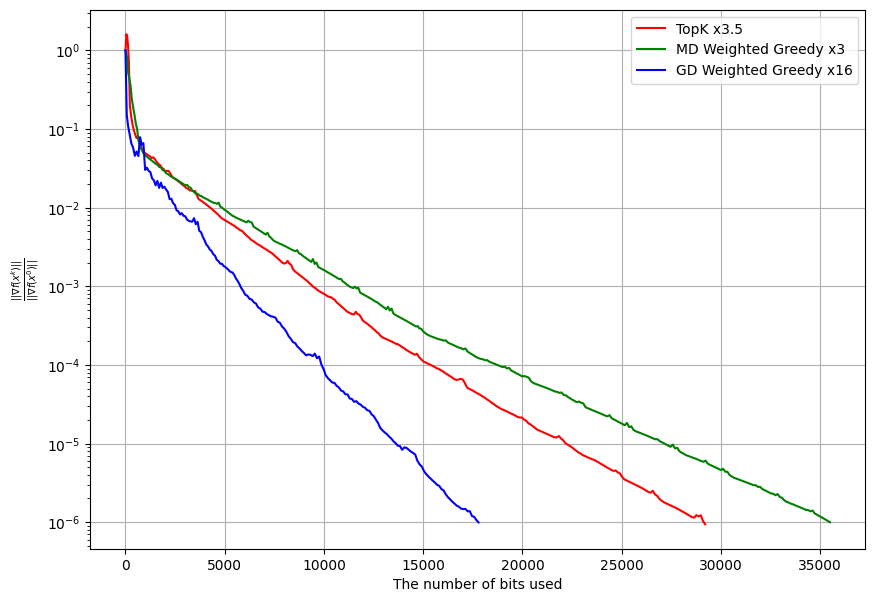

In [4]:
np.random.seed(SEED)
use_ratio = 0.2

grad = lambda x: logreg_grad(x, args['X'], args['y'], args['alpha'])

compressor1 = GreedyCompressor(grad, len(x_0), use_ratio)

compressor2 = MirrorDescentWeightedTopkCompressor(grad, 3./L, len(x_0), use_ratio)
compressor3 = GradientDescentWeightedTopkCompressor(grad, 16./L, len(x_0), use_ratio)

approximator1 = BitNormGradientApproximator(compressor1, func_name, args)
approximator2 = BitNormGradientApproximator(compressor2, func_name, args)
approximator3 = BitNormGradientApproximator(compressor3, func_name, args)

max_bits = 7 * 10**4

optimizers_list = [
    GDOptimizer(approximator1, 3.5/L, x_0, max_bits=max_bits),
    GDOptimizer(approximator2, 3./L, x_0, max_bits=max_bits),
    GDOptimizer(approximator3, 16./L, x_0, max_bits=max_bits)
]

for opt in optimizers_list:
    opt.optimize()
make_err_plot(optimizers_list, labels=[f"TopK x{3.5}", f"MD Weighted Greedy x{3}", f"GD Weighted Greedy x{16}"], title="")

In [ ]:
p.random.seed(SEED)
use_ratio = 0.2

grad = lambda x: logreg_grad(x, args['X'], args['y'], args['alpha'])
lr_multipliers = [16., 24.]

compressors1 = [GreedyCompressor(grad, len(x_0), use_ratio)]

compressors2 = []
for lr_multiplier in lr_multipliers:
    compressors2 += [GradientDescentWeightedTopkCompressor(grad, lr_multiplier/L, len(x_0), use_ratio)]

approximators1 = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors1]
approximators2 = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors2]

num_calls = 10**5

optimizers_list = [
    GDOptimizer(approximator, lr_multiplier/L, x_0, max_bits=num_calls) for lr_multiplier, approximator in zip([3.], approximators1)
]

optimizers_list += [
    GDOptimizer(approximator, lr_multiplier/L, x_0, max_bits=num_calls) for lr_multiplier, approximator in zip(lr_multipliers, approximators2)
]

for opt in optimizers_list:
    opt.optimize()
make_err_plot(optimizers_list, labels=[f"TopK x{3.}"] + [f"GD Weighted Greedy x{lr}" for lr in lr_multipliers], title="")

Добавить выбор шага

 65%|██████▌   | 363/558 [00:02<00:01, 174.71it/s]


Precision 1e-06 achieved at step 363!


 54%|█████▎    | 299/558 [00:01<00:01, 174.24it/s]


Precision 1e-06 achieved at step 299!


 64%|██████▎   | 355/558 [01:05<00:37,  5.40it/s]


Precision 1e-06 achieved at step 355!


 75%|███████▍  | 417/558 [01:18<00:26,  5.30it/s]


Precision 1e-06 achieved at step 417!


100%|██████████| 558/558 [01:52<00:00,  4.98it/s]


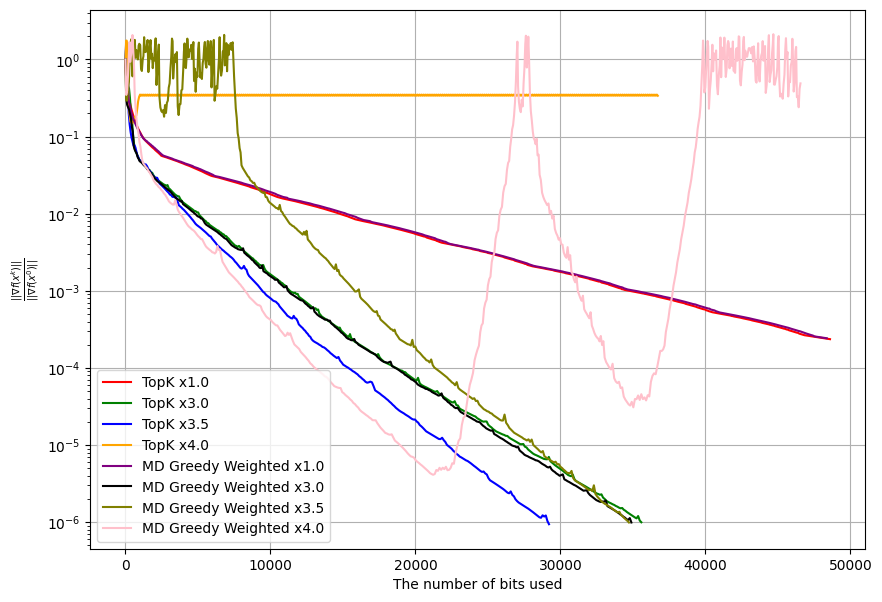

In [5]:
np.random.seed(SEED)
use_ratio = 0.2

grad = lambda x: logreg_grad(x, args['X'], args['y'], args['alpha'])
lr_multipliers = [1., 3.0, 3.5, 4.,]

compressors1 = []
for lr_multiplier in lr_multipliers:
    compressors1 += [GreedyCompressor(grad, len(x_0), use_ratio)]

compressors2 = []
for lr_multiplier in lr_multipliers:
    compressors2 += [MirrorDescentGreedyWeightedCompressor(grad, lr_multiplier/L, len(x_0), use_ratio)]

approximators1 = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors1]
approximators2 = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors2]

num_calls = 10**5

optimizers_list = [
    GDOptimizer(approximator, lr_multiplier/L, x_0, max_bits=num_calls) for lr_multiplier, approximator in zip(lr_multipliers, approximators1)
]

optimizers_list += [
    GDOptimizer(approximator, lr_multiplier/L, x_0, max_bits=num_calls) for lr_multiplier, approximator in zip(lr_multipliers, approximators2)
]

for opt in optimizers_list:
    opt.optimize()
make_err_plot(optimizers_list, labels=[f"TopK x{lr}" for lr in lr_multipliers] + [f"MD Greedy Weighted x{lr}" for lr in lr_multipliers], title="")

Стартовать из нормы градиента, посмотреть откорректирует ли MD

Посмотреть, можно ли просто на градиент по w посмотреть и понять решение MD. Подумать про теорию для этого.

 67%|██████▋   | 1126/1675 [00:09<00:04, 122.45it/s]


Precision 1e-06 achieved at step 1126!


 65%|██████▍   | 1088/1675 [03:06<01:40,  5.82it/s]


Precision 1e-06 achieved at step 1088!


 85%|████████▌ | 1430/1675 [04:48<00:49,  4.96it/s]


Precision 1e-06 achieved at step 1430!


 72%|███████▏  | 1203/1675 [00:07<00:03, 156.18it/s]


Precision 1e-06 achieved at step 1203!


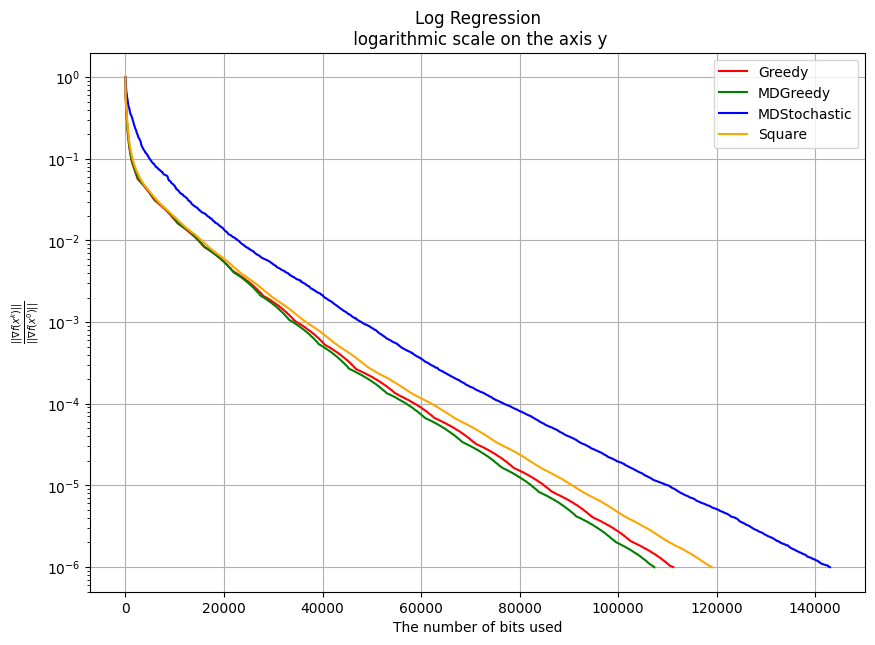

In [ ]:
np.random.seed(SEED)
use_ratio = 0.2

grad = lambda x: logreg_grad(x, args['X'], args['y'], args['alpha'])

compressors = [GreedyCompressor(grad, len(x_0), use_ratio)]
compressors += [MirrorDescentGreedyCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [MirrorDescentCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [SquareGradientCompressor(grad, len(x_0), use_ratio)]

approximators = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors]

num_calls =  3 * 10**5

optimizers_list = [
    GDOptimizer(approximator, learning_rate_GD, x_0, max_bits=num_calls) for approximator in approximators
]

for opt in optimizers_list:
    opt.optimize()
make_err_plot(optimizers_list, labels=[f"Greedy", "MDGreedy", "MDStochastic", "SquareStochastic"], title="Log Regression")

100%|██████████| 357/357 [00:02<00:00, 172.86it/s]


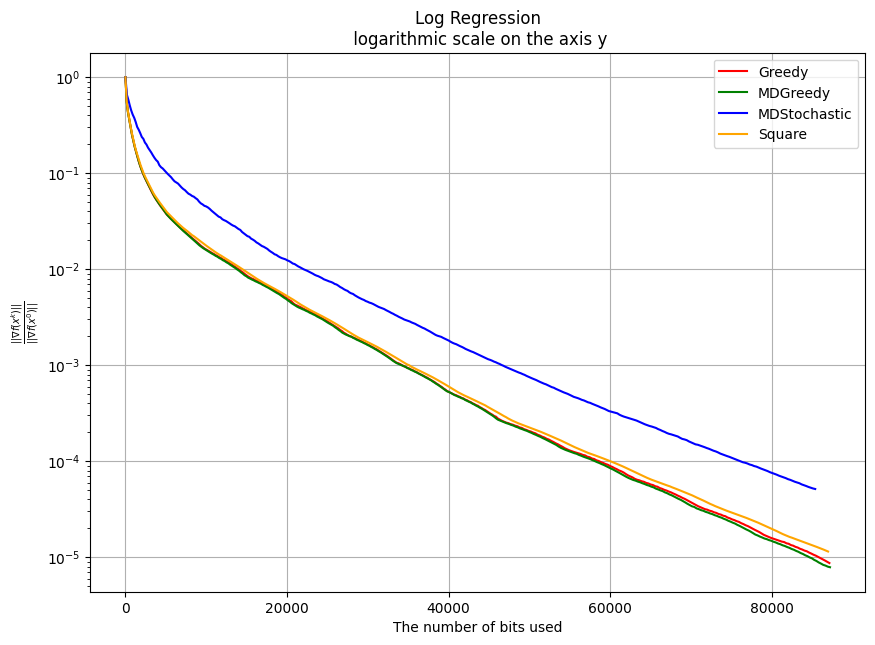

In [25]:
np.random.seed(SEED)
use_ratio = 0.5

grad = lambda x: logreg_grad(x, args['X'], args['y'], args['alpha'])

compressors = [GreedyCompressor(grad, len(x_0), use_ratio)]
compressors += [MirrorDescentGreedyCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [MirrorDescentCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [SquareGradientCompressor(grad, len(x_0), use_ratio)]

approximators = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors]

num_calls = 10**5

optimizers_list = [
    GDOptimizer(approximator, learning_rate_GD, x_0, max_bits=num_calls) for approximator in approximators
]

for opt in optimizers_list:
    opt.optimize()
make_err_plot(optimizers_list, labels=[f"Greedy", "MDGreedy", "MDStochastic", "Square"], title="Log Regression")

In [6]:
# adding noise components

args['X'] = np.hstack((args['X'], np.random.rand(*args['X'].shape)))
d = 224

np.random.seed(SEED)
x_0 = np.random.random(size=d)
x_0 = x_0 / np.linalg.norm(x_0) * 0.5


100%|██████████| 279/279 [00:04<00:00, 65.91it/s]


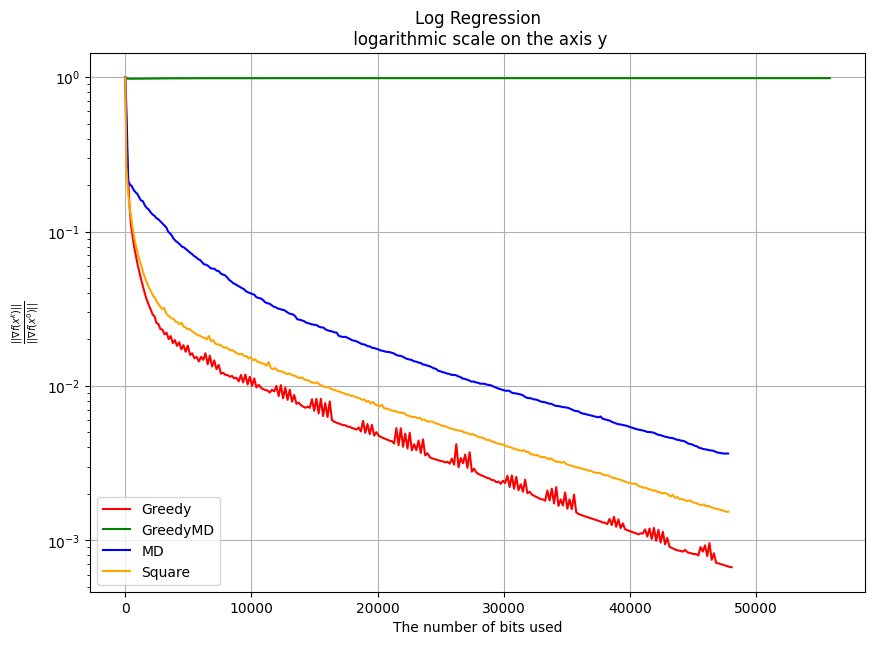

In [7]:
np.random.seed(SEED)

use_ratio = 0.2

grad = lambda x: logreg_grad(x, args['X'], args['y'], args['alpha'])

compressors = [GreedyCompressor(grad, len(x_0), use_ratio)]
compressors += [MirrorDescentGreedyCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [MirrorDescentCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [SquareGradientCompressor(grad, len(x_0), use_ratio)]

approximators = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors]

num_calls = 10**5

optimizers_list = [
    GDOptimizer(approximator, learning_rate_GD, x_0, max_bits=num_calls) for approximator in approximators
]

for opt in optimizers_list:
    opt.optimize()
make_err_plot(optimizers_list, labels=[f"Greedy", "GreedyMD", "MD", "Square"], title="Log Regression")